In [226]:
# Data management and investigation
import pandas as pd
import numpy as np
import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

from functools import reduce

In [139]:
# import 2019 reliability, net metering, energy efficiency, advanced metering infrastructure, demand response, and service territory data
reliability_19 = pd.read_excel("Data/Reliability_2019.xlsx", 
                               header = 1)
net_metering_19 = pd.read_excel("Data/Net_Metering_2019.xlsx", 
                                header = [0,1,2])
efficiency_19 = pd.read_excel("Data/Energy_Efficiency_2019.xlsx", 
                              header = [0,1,2])
demand_response_19 = pd.read_excel("Data/Demand_Response_2019.xlsx", 
                              header = [0,1,2])
territory_19 = pd.read_excel("Data/Service_Territory_2019.xlsx")

In [140]:
# Combine the headers together to describe each column
net_metering_19.columns = net_metering_19.columns.map(' - '.join)
efficiency_19.columns = efficiency_19.columns.map(' - '.join)
demand_response_19.columns = demand_response_19.columns.map(' - '.join)

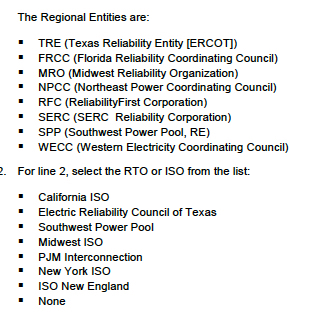

In [141]:
# only grab the columns I want from each dataframe
reliability_19 = reliability_19[['Utility Number',
              'Utility Name', 
              'State',
              'Ownership',
              'Number of Customers',
              'SAIDI Without MED',
              'SAIFI Without MED', 
              'CAIDI Without MED']].dropna()

In [157]:
reliability_19.columns = ['no', 'name', 'state','type', 'customers','saidi_nomed', 'saifi_nomed', 'caidi_nomed']

In [143]:
net_metering_19 = net_metering_19[['Utility Characteristics - Unnamed: 3_level_1 - Utility Name',
                'Photovoltaic - Capacity MW - Total',
                'Photovoltaic - Storage Capacity (MW) - Total',
                'Photovoltaic - Virtual Capacity (MW) - Total',
                'Wind - Capacity MW - Total',
                'All Technologies - Capacity MW - Total']].dropna()

In [144]:
net_metering_19.columns = ['name', 'pv_mw', 'pv_storage_mw', 'virtual_mw', 'wind_mw', 'all_tech_mw']

In [145]:
efficiency_19 = efficiency_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                  'Reporting Year Incremental Annual Savings - Energy Savings (MWh) - Total',
                 'Reporting Year Incremental Annual Savings - Peak Demand Savings (MW) - Total']].dropna()

In [146]:
efficiency_19.columns = ['name','ee_savings_mw', 'peak_savings_mw']

In [147]:
demand_response_19 = demand_response_19[['Utility Characteristics - Unnamed: 2_level_1 - Utility Name',
                    'Yearly Energy and Demand Savings - Number of Customers Enrolled - Total',
                    'Yearly Energy and Demand Savings - Energy Savings (MWh) - Total']].dropna()

In [148]:
demand_response_19.columns = ['name', 'dem_res_customers', 'dem_res_savings_mwh']

In [149]:
territory_19 = territory_19[['Utility Number',
             'Utility Name',
             'State',
             'County']]

In [150]:
territory_19.columns = ['no', 'name', 'state', 'county']

In [151]:
reliability_19.shape

(1184, 8)

In [158]:
# merge all the lists together by utility name 
df_list = [reliability_19, net_metering_19, efficiency_19, demand_response_19]
df_19 = reduce(lambda left,right: pd.merge(left,right,on='name', how='outer'), df_list)

In [159]:
# drop all the entries where my outcome variable is not present (SAIDI, SAIFI and CAIDI are same – I checked)
df_19 = df_19[~df_19.saidi_nomed.isna()]

In [160]:
# drop the duplicate rows 
df_19 = df_19[~df_19.duplicated(['name', 'state'])]

### Need to justify using SAIDI rather than SAIFI or CAIDI

In [182]:
# limit dataframe to SAIDI, which has the most nonzero entries (770) 
df_19 = df_19[(df_19.saidi_nomed != 0)].reset_index(drop=True)

In [186]:
# fill na's with 0 
df_19 = df_19.fillna(0)

In [188]:
df_19.describe()

,no,customers,saidi_nomed,saifi_nomed,caidi_nomed,pv_mw,pv_storage_mw,virtual_mw,wind_mw,all_tech_mw,ee_savings_mw,peak_savings_mw,dem_res_customers,dem_res_savings_mwh
count,770.000000,7.700000e+02,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,7.700000e+02,770.000000,770.000000,770.000000
mean,12294.633766,1.544447e+05,138.782414,1.163474,95.765853,28.165491,0.321249,0.791822,0.260487,29.847940,3.113068e+04,7.566097,13388.080519,1702.947826
std,8554.785067,4.766155e+05,140.956411,1.034872,63.567703,201.309299,4.461121,12.714171,2.135177,211.537199,1.324301e+05,33.253440,72183.367329,35740.719514
min,97.000000,4.100000e+01,0.655000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,5879.000000,1.107900e+04,55.798000,0.507750,66.627713,0.010000,0.000000,0.000000,0.000000,0.022750,0.000000e+00,0.000000,0.000000,0.000000
50%,12264.000000,2.409100e+04,99.848500,0.995500,91.777437,0.349500,0.000000,0.000000,0.000000,0.456000,0.000000e+00,0.000000,0.000000,0.000000
75%,16733.000000,6.557075e+04,170.164250,1.528000,120.542700,2.215500,0.000000,0.000000,0.027000,2.671750,1.573815e+03,0.351250,76.000000,0.000000
max,60839.000000,5.589368e+06,1239.300000,12.386000,1075.000000,4265.184000,96.415000,343.869000,40.337000,4473.646000,2.097423e+06,436.743000,895133.000000,977215.000000


In [187]:
df_19.sort_values(by='name')

,no,name,state,type,customers,saidi_nomed,saifi_nomed,caidi_nomed,pv_mw,pv_storage_mw,virtual_mw,wind_mw,all_tech_mw,ee_savings_mw,peak_savings_mw,dem_res_customers,dem_res_savings_mwh
221,6641.0,4-County Electric Power Assn,MS,Cooperative,47963.0,125.820,1.470,85.591837,0.000,0.0,0.00,0.000,0.000,0.0,0.000,0.0,0.0
82,3278.0,AEP Texas Central Company,TX,Investor Owned,855355.0,167.000,1.623,102.895870,0.000,0.0,0.00,0.000,0.000,58366.6,39.700,81.0,103.0
705,20404.0,AEP Texas North Company,TX,Investor Owned,193284.0,111.200,1.134,98.059965,0.000,0.0,0.00,0.000,0.000,12223.0,6.700,23.0,21.0
402,12647.0,"ALLETE, Inc.",MN,Investor Owned,143598.0,144.020,1.350,106.681480,7.160,0.0,1.04,0.175,8.375,61243.0,7.522,7897.0,746.0
0,97.0,Adams Electric Coop,IL,Cooperative,8665.0,169.740,1.290,131.581400,0.145,0.0,0.00,0.014,0.159,0.0,0.000,4402.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,21079.0,Wyrulec Company,NE,Cooperative,499.0,353.521,2.228,158.671900,0.045,0.0,0.00,0.000,0.045,0.0,0.000,0.0,0.0
724,21079.0,Wyrulec Company,WY,Cooperative,4822.0,164.019,1.128,145.406910,0.045,0.0,0.00,0.000,0.045,0.0,0.000,0.0,0.0
722,21075.0,Y-W Electric Assn Inc,CO,Cooperative,8937.0,62.700,0.000,0.000000,0.057,0.0,0.00,0.190,0.247,112.7,0.000,0.0,0.0
725,21081.0,Yampa Valley Electric Assn Inc,CO,Cooperative,27438.0,203.500,2.421,84.056175,0.604,0.0,0.00,0.020,0.624,0.0,0.000,0.0,0.0


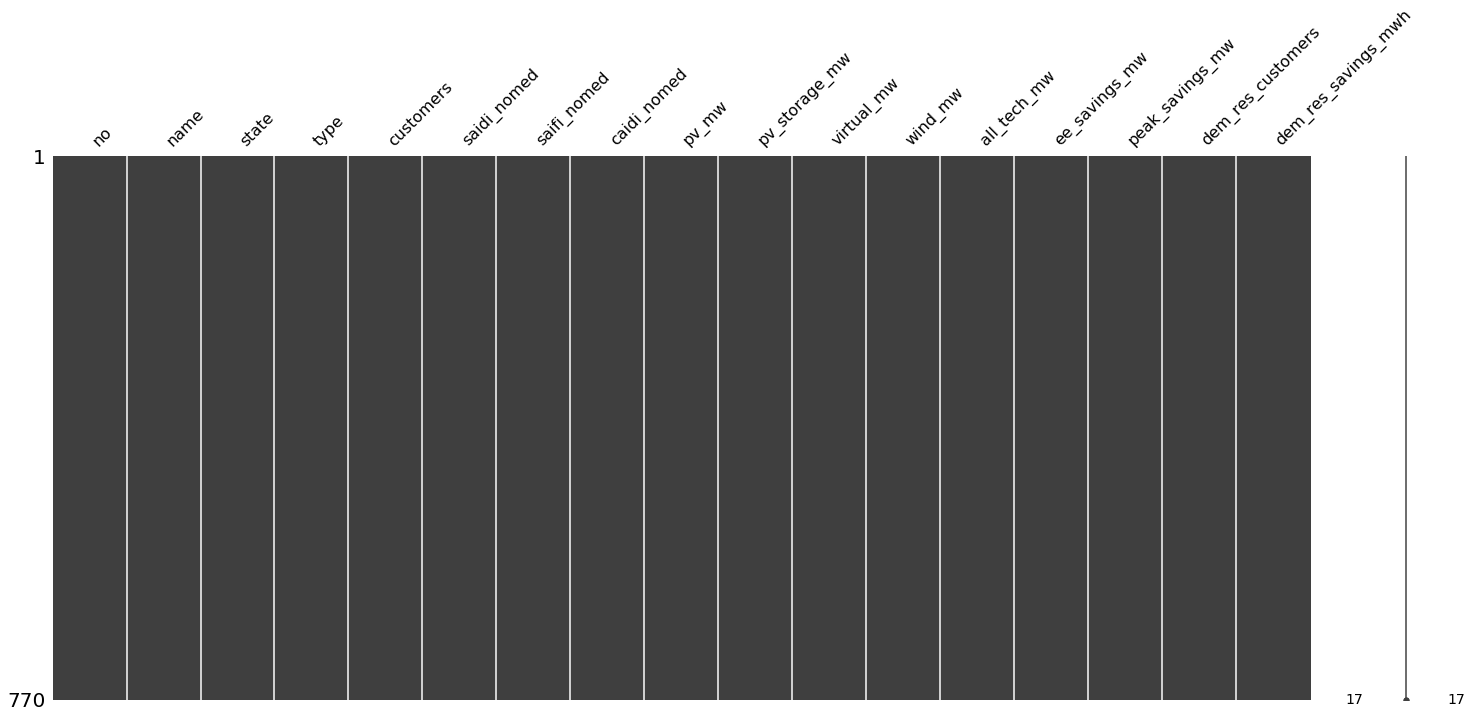

In [209]:
# make sure we're good to go
msno.matrix(df_19)

In [206]:
# export as CSV so I can use it in my next step
df_19.to_csv("df_19.csv",index=False)

## Unresolved pile

In [92]:
# there's a problem - when we mergeed our dataframes, they dropped all the adjustments
net_metering_19[net_metering_19['name'].str.contains("Adjustment")]

,name,pv_mw,pv_storage_mw,virtual_mw,wind_mw,all_tech_mw
1307,Adjustment 2019,-0.002,0.0,0.000,0.0,-0.002
1308,Adjustment 2019,-0.003,0.0,0.000,0.0,-0.003
1309,Adjustment 2019,-0.004,0.0,0.000,0.0,-0.004
1310,Adjustment 2019,-0.007,0.0,0.000,0.0,-0.007
1311,Adjustment 2019,-0.007,0.0,0.000,0.0,-0.007
...,...,...,...,...,...,...
1385,Adjustment 2019,-28.362,0.0,0.000,0.0,-28.362
1386,Adjustment 2019,-35.734,0.0,0.000,0.0,-35.734
1387,Adjustment 2019,-54.965,0.0,0.000,0.0,-54.965
1388,Adjustment 2019,-59.486,0.0,-0.108,0.0,-59.594


# Discard pile

In [ ]:
# was going to use to merge columns but not necessary
#cols = [col for col in net_metering_19.columns if 'Unnamed:' not in col]